In [138]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch.nn.functional as F
import torch_geometric
import kmbio  # fork of biopython PDB with some changes in how the structure, chain, etc. classes are defined.
import numpy as np
import pandas as pd
import proteinsolver
import modules
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, BatchSampler
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import *
from torch import nn, optim
from pathlib import Path

from modules.dataset_utils import *
from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

from scipy.stats import ttest_ind, describe, ttest_rel

np.random.seed(0)
torch.manual_seed(0)

In [2]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed" / "tcr_binding"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "state_files" / "tcr_binding"

### Load data

In [199]:
metadata

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path,merged_chains
0,1,AVSQSNTGKLI,ASSQLMENTEAF,NLVPMVATV,1,0,TRAV12-2,TRAJ37,TRBV4-1,TRBJ1-1,tenX,TRAV12-2*01,TRAJ37*01,TRBV4-1*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVSQSNTGKLIASSQLMENTEAF
1,2,AASEVCADYKLS,ASSYSLLRAAPNTEAF,NLVPMVATV,1,0,TRAV29DV5,TRAJ20,TRBV6-3,TRBJ1-1,tenX,TRAV29/DV5*01,TRAJ20*01,TRBV6-3*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AASEVCADYKLSASSYSLLRAAPNTEAF
2,3,AGRLGAQKLV,ASSQGGRRNQPQH,NLVPMVATV,1,0,TRAV25,TRAJ54,TRBV4-2,TRBJ1-5,tenX,TRAV25*01,TRAJ54*01,TRBV4-2*01,TRBJ1-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AGRLGAQKLVASSQGGRRNQPQH
3,4,AVEPLYGNKLV,ASSSREAEAF,NLVPMVATV,1,0,TRAV22,TRAJ47,TRBV7-9,TRBJ1-1,tenX,TRAV22*01,TRAJ47*01,TRBV7-9*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVEPLYGNKLVASSSREAEAF
4,5,ASGTYKYI,ASSQRAGRVDTQY,NLVPMVATV,1,0,TRAV19,TRAJ40,TRBV27,TRBJ2-3,tenX,TRAV19*01,TRAJ40*01,TRBV27*01,TRBJ2-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...,ASGTYKYIASSQRAGRVDTQY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,12961,AVNSYYNQGGKLI,SVLQGSPYEQY,GILGFVFTL,1,1,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,positive,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVNSYYNQGGKLISVLQGSPYEQY
10327,12962,AGNYGGSQGNLI,ASSIYSVNEQF,GILGFVFTL,1,1,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,positive,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AGNYGGSQGNLIASSIYSVNEQF
10328,12966,AVGGSQGNLI,ASSVRSSYEQY,GILGFVFTL,1,1,TRAV8-6*02,TRAJ42*01,TRBV19*01,TRBJ2-7*01,positive,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVGGSQGNLIASSVRSSYEQY
10329,12968,AENGGGGADGLT,ASSIRSSYEQY,GILGFVFTL,1,1,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,positive,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AENGGGGADGLTASSIRSSYEQY


In [3]:
model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)

loo_train_partitions, loo_valid_partitions, unique_peptides = generate_loo_partitions(metadata)

dataset = LSTMDataset(
    data_dir=processed_dir / "gnn_out_pos_128", 
    annotations_path=processed_dir / "gnn_out_pos_128" / "targets.pt"
)

In [153]:
swapped_idx = metadata[metadata["origin"] == "swapped"].index
non_swapped_loo_valid_partitions = list()
for part in loo_valid_partitions:
    new_part = [x for x in part if x not in swapped_idx]
    non_swapped_loo_valid_partitions.append(new_part)

### Load model and make predictions

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/archive/filter_cdr3b_and_cdr3a/50f2df244c395d50d6d8712860e754a3")
state_paths = [data_dir / f"state_{i}.pt" for i in range(len(unique_peptides))]

true_all = list()
pred_all = list()

loo_valid = loo_valid_partitions

for i in range(len(unique_peptides)):
    
    print("Peptide:", unique_peptides[i])

    net = QuadLSTM(
        embedding_dim=128,
        hidden_dim=128,
        num_layers=3,
        dropout=0.8,
    )
    net.load_state_dict(torch.load(state_paths[i], map_location=device))
    #test_data = loo_valid_partitions[pep_idx]
    test_data = loo_valid[i]
    pred, true = lstm_quad_predict(net, dataset, test_data, device)
    true_all.append(true)
    pred_all.append(pred)

pred_flatten = torch.hstack(pred_all)
true_flatten = torch.hstack(true_all)

# loss analysis
bce_loss = torch.nn.BCELoss()
pred_loss = list()
with torch.no_grad():
    for p, t in zip(pred_flatten, true_flatten):
        pred_loss.append(bce_loss(p, t).item())

Peptide: NLVPMVATV
Peptide: SLFNTVATL
Peptide: KTWGQYWQV
Peptide: RTLNAWVKV
Peptide: KVLEYVIKV
Peptide: YLLEMLWRL
Peptide: IMDQVPFSV
Peptide: MLDLQPETT
Peptide: FLYALALLL
Peptide: SLLMWITQV
Peptide: LLFGYPVYV
Peptide: GLCTLVAML
Peptide: RMFPNAPYL
Peptide: GILGFVFTL
Peptide: KLQCVDLHV
Peptide: KVAELVHFL


AUC: 0.8333333333333334


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


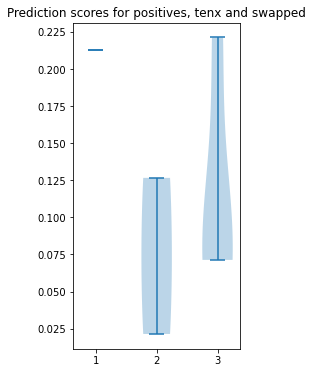

Positive stats:  DescribeResult(nobs=1, minmax=(0.2130553275346756, 0.2130553275346756), mean=0.2130553275346756, variance=nan, skewness=0.0, kurtosis=-3.0)

Tenx stats:  DescribeResult(nobs=2, minmax=(0.021427156403660774, 0.12664607167243958), mean=0.07403661403805017, variance=0.005535510065169226, skewness=0.0, kurtosis=-2.0)

Swapped stats:  DescribeResult(nobs=4, minmax=(0.07135436683893204, 0.2212609052658081), mean=0.11385968141257763, variance=0.00518656455498058, skewness=1.1158053845057232, kurtosis=-0.6992824380480762)

Positives vs. tenX two-way T-test:  Ttest_indResult(statistic=nan, pvalue=nan)
Positives vs. swapped two-way T-test:  Ttest_indResult(statistic=nan, pvalue=nan)
swapped vs. tenX two-way T-test:  Ttest_indResult(statistic=0.6246499243994522, pvalue=0.5957015159731095)


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [197]:
auc = roc_auc_score(true, pred)
print("AUC:", auc)

key = np.array(metadata.iloc[test_data]["origin"])
data = np.array(np.array([pred.numpy(), key]))

tenx = data[0][data[1,] == "tenX"].astype(float)
swapped = data[0][data[1,] == "swapped"].astype(float)
positives = data[0][data[1,] == "positive"].astype(float)

# Create an axes instance
fig, ax = plt.subplots(figsize=(3, 6))

# Create the boxplot
ax.violinplot([positives, tenx, swapped])
ax.set_title("Prediction scores for positives, tenx and swapped")

plt.show()

print("Positive stats: ", describe(positives))
print()
print("Tenx stats: ", describe(tenx))
print()
print("Swapped stats: ", describe(swapped))
print()
print("Positives vs. tenX two-way T-test: ", ttest_ind(positives, tenx, equal_var=False))
print("Positives vs. swapped two-way T-test: ", ttest_ind(positives, swapped, equal_var=False))
print("swapped vs. tenX two-way T-test: ", ttest_ind(swapped, tenx, equal_var=False))




AUC: 0.5669208146412086
MCC (t=0.1): -0.03914882991210548


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


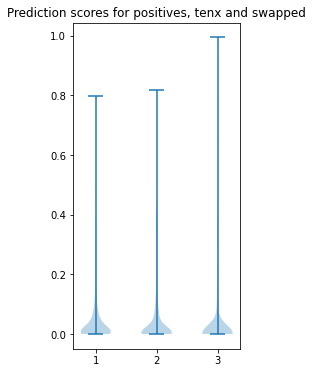

Positive stats:  DescribeResult(nobs=1810, minmax=(1.1246300346101634e-05, 0.7980820536613464), mean=0.04626288706696055, variance=0.006750820313070992, skewness=2.9882648361419917, kurtosis=10.97670678486648)

TenX stats:  DescribeResult(nobs=6699, minmax=(1.1697486115735956e-05, 0.8191697001457214), mean=0.06250205562102934, variance=0.012270134150923097, skewness=2.1712366003598875, kurtosis=4.32243443878418)

Swapped stats:  DescribeResult(nobs=1811, minmax=(1.1720622751454357e-05, 0.9942935109138489), mean=0.042100620173328676, variance=0.014543084999322777, skewness=4.242725623136483, kurtosis=21.685740465143137)

Positives vs. tenX two-way T-test:  Ttest_indResult(statistic=-6.88609214267353, pvalue=6.688086992488282e-12)
Positives > tenX one-way T-test:  Ttest_indResult(statistic=-6.88609214267353, pvalue=0.9999999999966559)
Positives vs. swapped two-way T-test:  Ttest_indResult(statistic=1.213733836696145, pvalue=0.2249391575306272)
swapped vs. tenX two-way T-test:  Ttest_indR

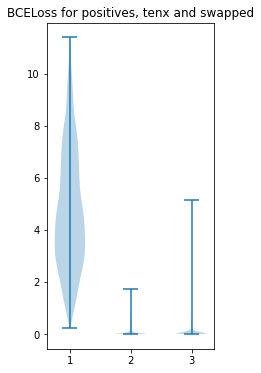

Positives vs. tenX two-way T-test:  Ttest_indResult(statistic=88.05322715473716, pvalue=0.0)
Positives vs. swapped two-way T-test:  Ttest_indResult(statistic=87.61815345319717, pvalue=0.0)
swapped vs. tenX two-way T-test:  Ttest_indResult(statistic=-1.5210294937803572, pvalue=0.12840565249451522)


In [215]:


auc = roc_auc_score(true_flatten, pred_flatten)

threshold = 0.1
thresh_pred = torch.zeros(len(pred_flatten))
thresh_pred[pred_flatten >= threshold] = 1
mcc = matthews_corrcoef(true_flatten, thresh_pred)
print("AUC:", auc)
print(f"MCC (t={threshold}):", mcc)

# prediction analysis
flattened_valid_idx = [x for y in loo_valid for x in y]
valid_df = metadata.iloc[flattened_valid_idx]
key = np.array(valid_df["origin"])
data = np.array(np.array([pred_flatten.numpy(), key]))

tenx = data[0][data[1,] == "tenX"].astype(float)
swapped = data[0][data[1,] == "swapped"].astype(float)
positives = data[0][data[1,] == "positive"].astype(float)

# Create an axes instance
fig, ax = plt.subplots(figsize=(3, 6))

# Create the boxplot
ax.violinplot([positives, tenx, swapped])
#ax.violinplot([positives, tenx])
ax.set_title("Prediction scores for positives, tenx and swapped")

plt.show()

print("Positive stats: ", describe(positives))
print()
print("TenX stats: ", describe(tenx))
print()
print("Swapped stats: ", describe(swapped))
print()
print("Positives vs. tenX two-way T-test: ", ttest_ind(positives, tenx, equal_var=False))
print("Positives > tenX one-way T-test: ", ttest_ind(positives, tenx, alternative="greater", equal_var=False))
print("Positives vs. swapped two-way T-test: ", ttest_ind(positives, swapped, equal_var=False))
print("swapped vs. tenX two-way T-test: ", ttest_ind(swapped, tenx, equal_var=False))



data_loss = np.array(np.array([pred_loss, key]))
tenx_loss = data_loss[0][data_loss[1,] == "tenX"].astype(float)
swapped_loss = data_loss[0][data_loss[1,] == "swapped"].astype(float)
positives_loss = data_loss[0][data_loss[1,] == "positive"].astype(float)

fig, ax = plt.subplots(figsize=(3, 6))
ax.violinplot([positives_loss, tenx_loss, swapped_loss])
ax.set_title("BCELoss for positives, tenx and swapped")
plt.show()

print("Positives vs. tenX two-way T-test: ", ttest_ind(positives_loss, tenx_loss, equal_var=False))
print("Positives vs. swapped two-way T-test: ", ttest_ind(positives_loss, swapped_loss, equal_var=False))
print("swapped vs. tenX two-way T-test: ", ttest_ind(swapped_loss, tenx_loss, equal_var=False))



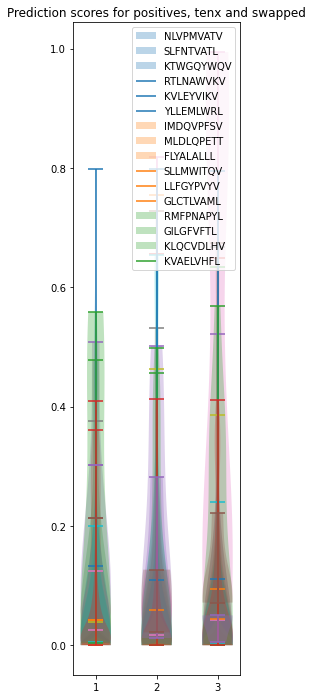

/tmp/ipykernel_160/629421353.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_loss = np.array(np.array([pred_loss, key]))


TypeError: only integer scalar arrays can be converted to a scalar index

In [217]:

#auc = roc_auc_score(true_flatten, pred_flatten)
#
#threshold = 0.1
#thresh_pred = torch.zeros(len(pred_flatten))
#thresh_pred[pred_flatten >= threshold] = 1
#mcc = matthews_corrcoef(true_flatten, thresh_pred)
#print("AUC:", auc)
#print(f"MCC (t={threshold}):", mcc)
#
# prediction analysis
fig, ax = plt.subplots(figsize=(3, 12))

for i, valid_idx in enumerate(loo_valid_partitions):
    valid_df = metadata.iloc[valid_idx]
    key = np.array(valid_df["origin"])
    data = np.array(np.array([pred_all[i].numpy(), key]))

    tenx = data[0][data[1,] == "tenX"].astype(float)
    swapped = data[0][data[1,] == "swapped"].astype(float)
    positives = data[0][data[1,] == "positive"].astype(float)

    # Create the boxplot
    ax.violinplot([positives, tenx, swapped])


ax.legend(unique_peptides)
ax.set_title("Prediction scores for positives, tenx and swapped")
plt.show()




data_loss = np.array(np.array([pred_loss, key]))
tenx_loss = data_loss[0][data_loss[1,] == "tenX"].astype(float)
swapped_loss = data_loss[0][data_loss[1,] == "swapped"].astype(float)
positives_loss = data_loss[0][data_loss[1,] == "positive"].astype(float)

fig, ax = plt.subplots(figsize=(3, 6))
ax.violinplot([positives_loss, tenx_loss, swapped_loss])
ax.set_title("BCELoss for positives, tenx and swapped")
plt.show()

print("Positives vs. tenX two-way T-test: ", ttest_ind(positives_loss, tenx_loss, equal_var=False))
print("Positives vs. swapped two-way T-test: ", ttest_ind(positives_loss, swapped_loss, equal_var=False))
print("swapped vs. tenX two-way T-test: ", ttest_ind(swapped_loss, tenx_loss, equal_var=False))



AUC: 0.529740358707781


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


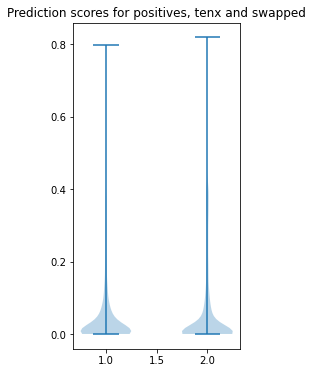

Positive stats:  DescribeResult(nobs=1810, minmax=(1.1246300346101634e-05, 0.7980820536613464), mean=0.04626288706696055, variance=0.006750820313070992, skewness=2.9882648361419917, kurtosis=10.97670678486648)

Positive tenx:  DescribeResult(nobs=6699, minmax=(1.1697486115735956e-05, 0.8191697001457214), mean=0.06250205562102934, variance=0.012270134150923097, skewness=2.1712366003598875, kurtosis=4.32243443878418)


Positives vs. tenX two-way T-test:  Ttest_indResult(statistic=-5.819377912892944, pvalue=6.120628573828395e-09)


In [177]:
auc = roc_auc_score(true_flatten, pred_flatten)
print("AUC:", auc)

flattened_valid_idx = [x for y in loo_valid for x in y]
valid_df = metadata.iloc[flattened_valid_idx]
key = np.array(valid_df["origin"])
data = np.array(np.array([pred_flatten.numpy(), key]))

tenx = data[0][data[1,] == "tenX"].astype(float)
#swapped = data[0][data[1,] == "swapped"].astype(float)
positives = data[0][data[1,] == "positive"].astype(float)

# Create an axes instance
fig, ax = plt.subplots(figsize=(3, 6))

# Create the boxplot
#ax.violinplot([positives, tenx, swapped])
ax.violinplot([positives, tenx])
ax.set_title("Prediction scores for positives, tenx and swapped")

plt.show()

print("Positive stats: ", describe(positives))
print()
print("Positive tenx: ", describe(tenx))
print()
#print("Positive swapped: ", describe(swapped))
print()
print("Positives vs. tenX two-way T-test: ", ttest_ind(positives, tenx, equal_var=False))
#print("Positives vs. swapped two-way T-test: ", ttest_ind(positives, swapped, equal_var=False))
#print("swapped vs. tenX two-way T-test: ", ttest_ind(swapped, tenx, equal_var=False))

In [194]:
from scipy import stats
rng = np.random.default_rng()
rvs1 = stats.norm.rvs(loc=5, scale=10, size=500, random_state=rng)
rvs2 = stats.norm.rvs(loc=7, scale=10, size=500, random_state=rng)
stats.ttest_ind(rvs2, rvs1, alternative="greater")

Ttest_indResult(statistic=2.8776288657908196, pvalue=0.002046087317281751)

In [188]:
np.mean(rvs2)

7.050082425769386

In [189]:
np.mean(rvs1)

4.695074304552389